# Use OSMnx to plot street network over place shape

Author: [Geoff Boeing](https://geoffboeing.com/)

This example uses Portland, Maine - a city with several islands within its municipal boundaries. Thus, we set `retain_all=True` when getting the network so that we keep all the graph components, not just the largest connected component.

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import matplotlib.pyplot as plt
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.0.0'

In [2]:
# get the place boundaries
place = 'Portland, Maine'
gdf = ox.geocode_to_gdf(place)

# get the street network, with retain_all=True to retain all the disconnected islands' networks
G = ox.graph_from_place(place, network_type='drive', retain_all=True)

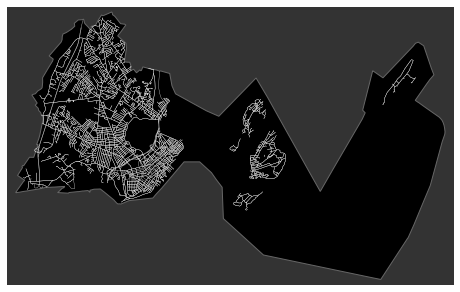

In [3]:
# plot the network, but do not show it or close it yet
fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor='#333333',
                        edge_color='w', edge_linewidth=0.3, node_size=0)

# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in gdf['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='k', ec='#666666', lw=1, alpha=1, zorder=-1)
            ax.add_patch(patch)

# optionally set up the axes extents
margin = 0.02
west, south, east, north = gdf.unary_union.bounds
margin_ns = (north - south) * margin
margin_ew = (east - west) * margin
ax.set_ylim((south - margin_ns, north + margin_ns))
ax.set_xlim((west - margin_ew, east + margin_ew))
plt.show()

Notice this municipal boundary is an administrative boundary, not a physical boundary, so it represents jurisdictional bounds, not individual physical features like islands. To get individual islands' geometries, use the `geometries` module:

In [4]:
islands = ox.geometries_from_place(place, tags={'place': ['island', 'islet']})
islands.shape

(27, 17)